# Pre-Equilibrium Maximazation of Yield #

In [1]:
# make sure jupyter path is correct for loading local moudules
import sys
# path to steric_simulator module relative to notebook
sys.path.append("../../../")
import copy

In [2]:
from KineticAssembly_AD import ReactionNetwork, VectorizedRxnNet, VecSim, Optimizer, EquilibriumSolver
import networkx as nx
import torch
from torch import DoubleTensor as Tensor
import numpy as np

EnergyExplorer Module is not available. Check Rosetta installation. <ipykernel.iostream.OutStream object at 0x7f7ecebb8c50>


We'll start with the AP2 complex that we've worked with before. Pairwise $\Delta Gs$ were derived from the PDB structures via Rossetta

In [3]:
base_input = '../input_files/tetramer_diversification.pwr'
rn = ReactionNetwork(base_input, one_step=True)
rn.resolve_tree()
vec_rn = VectorizedRxnNet(rn, dev='cpu')

['default_assoc', 1.0]
['rxn_coupling', True]
True
['monomer_add_only', False]
New node added - Node index: 4 ; Node label: AM 
New node added - Node index: 5 ; Node label: AB 
New node added - Node index: 6 ; Node label: AS 
Trying internal bonds
New node added - Node index: 7 ; Node label: BM 
New node added - Node index: 8 ; Node label: MS 
New node added - Node index: 9 ; Node label: ABM 
New node added - Node index: 10 ; Node label: AMS 
Trying internal bonds
New node added - Node index: 11 ; Node label: BS 
New node added - Node index: 12 ; Node label: ABS 
New node added - Node index: 13 ; Node label: BMS 
New node added - Node index: 14 ; Node label: ABMS 
The number of bonds formed are not compensated by the number of edges
This could be possible due to presence of a repeating subunit
SOurce1:  2 10
The common reactant is:  B
Edge added between:  2 14
Trying internal bonds
The number of bonds formed are not compensated by the number of edges
This could be possible due to prese

In [4]:
uid_dict = {}
sys.path.append("../../")
import numpy as np
from reaction_network import gtostr
for n in rn.network.nodes():
    #print(n)
    #print(rn.network.nodes()[n])
    print(n,"--",gtostr(rn.network.nodes[n]['struct']))
    for k,v in rn.network[n].items():
        uid = v['uid']
        r1 = set(gtostr(rn.network.nodes[n]['struct']))
        p = set(gtostr(rn.network.nodes[k]['struct']))
        r2 = p-r1
        reactants = (r1,r2)
        uid_dict[(n,k)] = uid

print(uid_dict)

0 -- A
1 -- M
2 -- B
3 -- S
4 -- AM
5 -- AB
6 -- AS
7 -- BM
8 -- MS
9 -- ABM
10 -- AMS
11 -- BS
12 -- ABS
13 -- BMS
14 -- ABMS
{(0, 4): 0, (0, 5): 1, (0, 6): 2, (0, 9): 19, (0, 10): 20, (0, 12): 21, (0, 14): 24, (1, 4): 0, (1, 7): 3, (1, 8): 4, (1, 9): 5, (1, 10): 6, (1, 13): 22, (1, 14): 23, (2, 5): 1, (2, 7): 3, (2, 11): 7, (2, 9): 8, (2, 12): 9, (2, 13): 10, (2, 14): 11, (3, 6): 2, (3, 8): 4, (3, 11): 7, (3, 10): 12, (3, 12): 13, (3, 13): 14, (3, 14): 15, (4, 9): 8, (4, 10): 12, (4, 14): 16, (5, 9): 5, (5, 12): 13, (5, 14): 17, (6, 10): 6, (6, 12): 9, (6, 14): 18, (7, 13): 14, (7, 14): 18, (7, 9): 19, (8, 13): 10, (8, 14): 17, (8, 10): 20, (9, 14): 15, (10, 14): 11, (11, 14): 16, (11, 12): 21, (11, 13): 22, (12, 14): 23, (13, 14): 24}


In [5]:
#Do modifications here
#Changing Initial Conditions
import networkx as nx
#Changin k_on
new_kon = torch.zeros([rn._rxn_count], requires_grad=True).double()
new_kon = new_kon + Tensor([1.]*np.array(1e-1))
new_kon[0:3]=3

update_kon_dict = {}
for edge in rn.network.edges:
    print(rn.network.get_edge_data(edge[0],edge[1]))
    update_kon_dict[edge] = new_kon[uid_dict[edge]]

nx.set_edge_attributes(rn.network,update_kon_dict,'k_on')


vec_rn = VectorizedRxnNet(rn, dev='cpu')
print(vec_rn.kon)



{'k_on': 1.0, 'k_off': None, 'lcf': 1, 'rxn_score': tensor([-20.], dtype=torch.float64), 'uid': 0}
{'k_on': 1.0, 'k_off': None, 'lcf': 1, 'rxn_score': tensor([-20.], dtype=torch.float64), 'uid': 1}
{'k_on': 1.0, 'k_off': None, 'lcf': 1, 'rxn_score': tensor([-20.], dtype=torch.float64), 'uid': 2}
{'k_on': 1.0, 'k_off': None, 'lcf': 1, 'rxn_score': tensor([-40.], dtype=torch.float64), 'uid': 19}
{'k_on': 1.0, 'k_off': None, 'lcf': 1, 'rxn_score': tensor([-40.], dtype=torch.float64), 'uid': 20}
{'k_on': 1.0, 'k_off': None, 'lcf': 1, 'rxn_score': tensor([-40.], dtype=torch.float64), 'uid': 21}
{'k_on': 1.0, 'k_off': None, 'lcf': 1, 'rxn_score': tensor([-60.], dtype=torch.float64), 'uid': 24}
{'k_on': 1.0, 'k_off': None, 'lcf': 1, 'rxn_score': tensor([-20.], dtype=torch.float64), 'uid': 0}
{'k_on': 1.0, 'k_off': None, 'lcf': 1, 'rxn_score': tensor([-20.], dtype=torch.float64), 'uid': 3}
{'k_on': 1.0, 'k_off': None, 'lcf': 1, 'rxn_score': tensor([-20.], dtype=torch.float64), 'uid': 4}
{'k_on

In [6]:
print(vec_rn.rxn_class)

{(1, 1): [0, 1, 2, 3, 4, 7], (2, 1): [5, 6, 8, 9, 10, 12, 13, 14, 19, 20, 21, 22], (3, 1): [11, 15, 23, 24], (2, 2): [16, 17, 18]}


## Using the optimizer ##

### Define an instance of the optimizer class
#### Input Arguments:

reaction_network : Input the vectorized rxn network

sim_runtime: The runtime of the kinetic simulation. Needs to be same as the time over the experimental reaction data.

optim_iterations: No. of iterations to run the optimization. Can start at low values(100) and increase depending upon memory usage.

learning_rate = The size of the gradient descent step for updating parameter values. Needs to be atleast (1e-3-1e-1)* min{parameter value}. If learning rate is too high, it can take a longer step and sometimes lead to negative value of parameters which is unphysical. Requires some trial runs to find the best value. 

device: cpu or gpu

method: Choose which pytorch based optimized to use for gradient descent - Adam or RMSprop

mom: Only for RMSprop method. Use momentum term during gradient descent. 


In [7]:
vec_rn.reset(reset_params=True)
optim = Optimizer(reaction_network=vec_rn,
                  sim_runtime=1,
                  optim_iterations=100,
                  learning_rate=1e-2,
                  device='cpu',method="RMSprop",)


### Call the optimization method

#### Input arguments

conc_scale, conc_thresh, mod_bool, mod_factor = As defined for the VecSim class. 

max_thresh: Max. allowed values of parameters being updated. Beyond this maximum a penalty is imposed on the cost function. (Regularization)

max_yield: It is a control variable that is used to store the updated parameter values over all iterations for further analysis. The parameter values are stored only if the current yield exceed this max_yield. 

yield_species: Yield of the species being optimized(node index). Default value is -1 (picks the last element from the array which is always the final complex for a fully connected topology)

In [8]:
optim.rn.update_reaction_net(rn)
optim.optimize(conc_scale=1,conc_thresh=1,max_thresh=10,yield_species=14)

Reaction Parameters before optimization: 
[Parameter containing:
tensor([3.0000, 3.0000, 3.0000, 0.1000, 0.1000, 0.1000], dtype=torch.float64,
       requires_grad=True)]
Optimizer State: <bound method Optimizer.state_dict of RMSprop (
Parameter Group 0
    alpha: 0.99
    centered: False
    eps: 1e-08
    lr: 0.01
    momentum: 0
    weight_decay: 0
)>
Using CPU
Yield on sim. iteration 0 was 89.9%.
current params: tensor([3.0000, 3.0000, 3.0000, 0.1000, 0.1000, 0.1000], dtype=torch.float64)
Using CPU
Yield on sim. iteration 1 was 93.3%.
current params: tensor([3.1000e+00, 3.1000e+00, 3.1000e+00, 2.0000e-01, 1.8913e-08, 3.5591e-08],
       dtype=torch.float64)
Using CPU
Yield on sim. iteration 2 was 85.2%.
current params: tensor([3.0000, 3.0000, 3.2000, 0.3000, 0.1000, 0.1000], dtype=torch.float64)
Using CPU
Yield on sim. iteration 3 was 84.2%.
current params: tensor([3.0013, 2.9956, 3.1992, 0.3123, 0.1257, 0.1105], dtype=torch.float64)
Using CPU
Yield on sim. iteration 4 was 83.4%.
c

Using CPU
Yield on sim. iteration 56 was 62.6%.
current params: tensor([2.6294, 2.7445, 2.6117, 0.9478, 0.6895, 0.7100], dtype=torch.float64)
Using CPU
Yield on sim. iteration 57 was 62.5%.
current params: tensor([2.6139, 2.7547, 2.5914, 0.9584, 0.6936, 0.7185], dtype=torch.float64)
Using CPU
Yield on sim. iteration 58 was 62.5%.
current params: tensor([2.6152, 2.7523, 2.5934, 0.9577, 0.6938, 0.7181], dtype=torch.float64)
Using CPU
Yield on sim. iteration 59 was 62.5%.
current params: tensor([2.6164, 2.7500, 2.5954, 0.9570, 0.6939, 0.7177], dtype=torch.float64)
Using CPU
Yield on sim. iteration 60 was 62.5%.
current params: tensor([2.6176, 2.7475, 2.5974, 0.9563, 0.6941, 0.7173], dtype=torch.float64)
Using CPU
Yield on sim. iteration 61 was 62.5%.
current params: tensor([2.6188, 2.7451, 2.5995, 0.9556, 0.6943, 0.7169], dtype=torch.float64)
Using CPU
Yield on sim. iteration 62 was 62.5%.
current params: tensor([2.6201, 2.7425, 2.6016, 0.9549, 0.6945, 0.7164], dtype=torch.float64)
Using 

## Track the yield over optim iterations

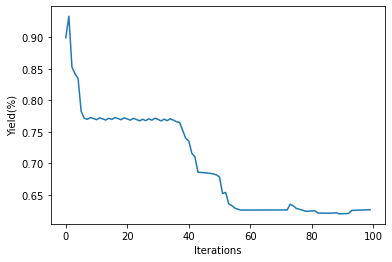

In [9]:
optim.plot_yield()

In [10]:
yields= []
final_params=[]
for i in range(len(optim.final_yields)):
    yields.append(optim.final_yields[i].item())
#     print(optim.final_solns[i].numpy())
    final_params.append(optim.final_solns[i].numpy())

sort_indx=np.argsort(np.array(yields))
sorted_yields=np.array(yields)[sort_indx]
sorted_params = np.array(final_params)[sort_indx]

p0 = sorted_params[0]
var_params = []
for i in range(len(sorted_params)):
    var_params.append(calc_var(p0,sorted_params[i]))
    
arg_indx = np.argsort(np.array(var_params))
sorted_var = np.array(var_params)[arg_indx]

print(sorted_var[0])
print(sorted_var[-1])
print("Yield: ",sorted_yields[arg_indx[0]],"\nParams: ",sorted_params[arg_indx[0]])

print("Yield: ",sorted_yields[arg_indx[-1]],"\nParams: ",sorted_params[arg_indx[-1]])
print("Max Yield: ",sorted_yields[-1],"\nParams: ",sorted_params[-1])

NameError: name 'calc_var' is not defined

In [ ]:
print(vec_rn.rx_cid)
print(vec_rn.coup_map)

In [ ]:
yields= []
final_params=[]
asymm = []
final_t50 = []
final_t85 = []
final_t95 = []
final_t99 = []
for i in range(len(optim.final_yields)):
    yields.append(optim.final_yields[i].item())
#     print(optim.final_solns[i].numpy())
    coupled_params=np.zeros(len(vec_rn.kon))
    if vec_rn.partial_opt:
        for j in range(len(vec_rn.kon)):
            if j in vec_rn.rx_cid.keys():
                all_rates=[]
                for rate in vec_rn.rx_cid[j]:
                    if rate in vec_rn.optim_rates:
                        all_rates.append(optim.final_solns[i][vec_rn.coup_map[rate]])
                    else:
                        if vec_rn.slow_rates is not None and rate in vec_rn.slow_rates:
                            all_rates.append(torch.mean(optim.final_solns[i][vec_rn.optim_rates])/vec_rn.slow_ratio)
                        else:
                            all_rates.append(vec_rn.kon[rate])
                coupled_params[j] = max(all_rates)
            else:
                if j in vec_rn.optim_rates:
                    coupled_params[j] = optim.final_solns[i][vec_rn.coup_map[j]]
                else:
                    if vec_rn.slow_rates is not None and j in vec_rn.slow_rates:       #Can be replaced later so that the RN figures out by iteself which are fast  interfaces and which are slow.
                        coupled_params[j] = torch.mean(optim.final_solns[i][vec_rn.optim_rates])/vec_rn.slow_ratio
                    else:
                        coupled_params[j] = vec_rn.kon[j]
    else:
        for j in range(len(vec_rn.kon)):
            if j in vec_rn.rx_cid.keys():
                #new_kon[i] = 1.0
                coupled_params[j] = max(optim.final_solns[i].numpy()[vec_rn.coup_map[rate]] for rate in vec_rn.rx_cid[j])
                # print("Max rate for reaction %s chosen as %.3f" %(i,self.coupled_kon[i]))
            else:
                coupled_params[j] = optim.final_solns[i].numpy()[vec_rn.coup_map[j]]
    final_params.append(coupled_params)
    
    if type(optim.final_t50[i])==int:
        final_t50.append(1) 
    else:
        final_t50.append(optim.final_t50[i].item()) 
    if type(optim.final_t85[i])==int:
        final_t85.append(1) 
    else:
        final_t85.append(optim.final_t85[i].item()) 
    if type(optim.final_t95[i])==int:
        final_t95.append(1)
    else:
        final_t95.append(optim.final_t95[i].item())

final_yield_arr = np.array(yields)
final_param_arr = np.array(final_params)
final_t85 = np.array(final_t85)
final_t95 = np.array(final_t95)



In [ ]:
import matplotlib.pyplot as plt

mask_r = final_yield_arr > 0.5

#Calculate the ratio
ratio = final_param_arr[:,1]/final_param_arr[:,0]

#Normalize the time scale (t = t*conc*max_rate)
conc=vec_rn.initial_copies[0].item()
scale_time = final_t95[mask_r]*conc*np.max(final_param_arr[mask_r],axis=1)
#Calculate the y_per_time
y_per_time = 0.95/scale_time

fig,ax = plt.subplots(figsize=(8,6))
ax.plot(ratio,y_per_time,linestyle='',marker='o')
ax.set_ylabel("Efficiency",fontsize=20)
ax.set_xlabel("Ratio",fontsize=20)
ax.tick_params(labelsize=25)
